In [1]:
from __future__ import print_function
import glob, os
import csv
import pandas as pd
from collections import OrderedDict
import _pickle as pickle
from datetime import datetime, timedelta
import numpy as np
from scipy import stats
from dateutil import parser
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# For Linux box ONLY

## This chunk of code PREPROCESSES raw sensor input (Interval Uniformization → Statistical Summarization → Integrity
## Remediation → Modeling Preparation)

### Definition:
### Interval Uniformization: Different sensors measure at varying intervals (from 5min to days), this process aligns all
### 35 variables to the same resolution, which is currently set at 30 min per PDO but can be easily adjusted;

### Statistical Summarization: Uses a summary statistic (mean, median…) to smooth over the raw data to prevent outliers,
### and to provide a single source of truth if multiple values occur in one resolution window – the statistic can be changed

### Integrity Remediation: Checks for integrity (data completeness and validity) and if missing values >5% the preprocessing
### pipeline will replenish (e.g. impute, carry forward) in accordance with “Integrity Mitigation Plan” formulated on 9/29;

### Modeling Preparation: For example, splitting data into 70/30 for training, testing respectively; transforming input
### vector space into feature space (e.g. onehot encoding); also references well failure records to map out “y” labels


import glob, os # packages for interfacing Linux operating system
import csv # crunches thru csv sensor dumps
import pandas as pd # data wrangling
from datetime import datetime, timedelta # enumerate timestamps
import numpy as np # array manipulation

ref = pd.read_excel("/data/ESP_Wells/Key_WO_Formulae.xlsx", sheet_name='VLOOKUP_RT_DATA') # prime decoder (un-hash labels)

for i in os.listdir("/data/ESP_Wells/ESP_Data"): # This is an outer loop iterating all wells' folders (e.g. W0001)
    print(i)                                     # (you can change to new dataset path)
    os.chdir("/data/ESP_Wells/ESP_Data/"+i)
    
    # create a master timesheet since designated start point in a specific resolution (e.g. 30 minutes)
    date_list = [x.strftime('%m/%d/%Y %H:%M') for x in [datetime(2015, 1, 1, 18) + timedelta(minutes=30*x) for x in \
                                                    range(0, abs(datetime.now()-datetime(2015, 1, 1, 18)).days*48)]]
    df = pd.DataFrame(date_list, index = None, columns = ['30min'])
    
    # defines a function to round a timestamp to its closest 30 minute designator (e.g. 10:35 to 10:30; 10:55 to 11:00)
    def round_minutes(dt, resolution): return dt + timedelta(minutes=(dt.minute // resolution + 1) * resolution - dt.minute)
    
    if os.path.isfile('median.csv')==True: # In case prior preprocessed result exists, append latest sensor readings
        print("Prior index located; appending...")
        f = pd.read_csv('median.csv', engine='c')
        last = list(f.sort_values(by = '30min',ascending = False)['30min'])[0] # last timestamp in prior result
        
        # create a master timesheet since last preprocessed slot till today in a specific resolution (e.g. 30 minutes)
        date_list = [x.strftime('%m/%d/%Y %H:%M') for x in [datetime.strptime(last, "%m/%d/%Y %H:%M") + timedelta(minutes=30*x)\
                                    for x in range(0, abs(datetime.now()-datetime.strptime(last, "%m/%d/%Y %H:%M")).days*48)]]
        df = pd.DataFrame(date_list, index = None, columns = ['30min'])
        
        for moni_file in glob.glob("*.csv"): # This is an inner loop iterating all contents of a well (e.g. W0001_Omega01.csv)
            if os.stat(moni_file).st_size <= 0 or '_' not in moni_file: # Omit/Skip dud files or those against naming convention
                continue
            var_name_ = moni_file.split('_')[1].split('.')[0] # extract label of sensor date being read (e.g. Omega1)
            # print(var_name_)
            test = pd.read_csv(moni_file, engine='c') # this is a critical step accelerating data ingestion by 10X
            # Uses the one function defined above to smooth all timestamps to regular 30 min sharp timestamps
            test['Rounding'] = [round_minutes(datetime.strptime(d, "%m/%d/%Y %I:%M:%S %p"), 30) for d in test["TimeStamp"]]
            # Curtail timestamps to a certain format '%m/%d/%Y %H:%M' while trimming the trailing seconds
            test['30min'] = [datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S").strftime('%m/%d/%Y %H:%M') for d in test["Rounding"]]
            # Excerpt data since a given timestamp, for example, Jan 1 2015
            test = test.loc[(test['Rounding']>=datetime.strptime(last, "%m/%d/%Y %H:%M"))]
            # Remove intermediate columns and retain 30min-apart timestamps
            test.drop(['TimeStamp', 'Rounding'], axis=1, inplace=True)
            # The following steps coerces non-numerical entries (readings) into either numerical (when possible) or null
            test = test[pd.to_numeric(test['Value'], errors='coerce').notnull()]
            test['Value'] = pd.to_numeric(test['Value'])
            # Uses median as the summary statistic to smooth out entire time series (change aggfunc for alternative stat)
            ## Some alternatives: np.mean, np.count_nonzero, np.min, np.max, np.ptp, np.std, stats.iqr, scipy.stats.mode
            test = test.pivot_table(aggfunc=np.median, columns=['30min'], values='Value', dropna=True, fill_value=0).T
            # Converts Pandas DataFrame to a NumPy record array
            test = pd.DataFrame(test.to_records())
            # The following steps ensures timestamps are adequately and appropriately ranked ascendingly (over-cautious)
            test['30min'] = [datetime.strptime(d,'%m/%d/%Y %H:%M') for d in test["30min"]]
            test = test.sort_values('30min')
            test['30min'] = [datetime.strptime(str(d),'%Y-%m-%d %H:%M:%S').strftime('%m/%d/%Y %H:%M') for d in test["30min"]]
            # Deciphers hashed value (e.g. Omega1) into interpretable labels (e.g. CasingHeadPressure) for easier reference
            test.rename(columns={'Value': dict(zip(ref.HashValues, ref.ColumnValue))[var_name_]}, inplace=True)
            # Splices processed time series with master timesheet created at the very beginning of this code
            df = pd.merge(df, test, how='left', on=["30min"])
            # Magic happens: reads in prior preprocessed result and splice via matching columns
            median_old = pd.read_csv('median.csv')     
            df2 = pd.concat(list(median_old.align(df)))
            df = df2.drop_duplicates(subset=['30min'], keep='first')
            df.to_csv('median.csv') # Overwrite prior preprocessed result and we have updated version
    else:
        print("Indexing from scratch...")
        for moni_file in glob.glob("*.csv"):
            # print(moni_file)# This is an inner loop iterating all contents of a well (e.g. W0001_Omega01.csv)
            if os.stat(moni_file).st_size <= 0 or '_' not in moni_file: # Omit/Skip dud files or those against naming convention
                continue
            var_name_ = moni_file.split('_')[1].split('.')[0] # extract label of sensor date being read (e.g. Omega1)
            test = pd.read_csv(moni_file, engine='c') # this is a critical step accelerating data ingestion by 10X
            # Uses the one function defined above to smooth all timestamps to regular 30 min sharp timestamps
            test['Rounding'] = [round_minutes(datetime.strptime(d, "%m/%d/%Y %I:%M:%S %p"), 30) for d in test["TimeStamp"]]
            # Curtail timestamps to a certain format '%m/%d/%Y %H:%M' while trimming the trailing seconds
            test['30min'] = [datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S").strftime('%m/%d/%Y %H:%M') for d in test["Rounding"]]
            # Excerpt data since a given timestamp, for example, Jan 1 2015
            test = test.loc[(test['Rounding']>=datetime.strptime('2015-01-1', '%Y-%m-%d'))]
            # Remove intermediate columns and retain 30min-apart timestamps
            test.drop(['TimeStamp', 'Rounding'], axis=1, inplace=True)
            # The following steps coerces non-numerical entries (readings) into either numerical (when possible) or null
            test = test[pd.to_numeric(test['Value'], errors='coerce').notnull()]
            test['Value'] = pd.to_numeric(test['Value'])
            # Uses median as the summary statistic to smooth out entire time series (change aggfunc for alternative stat)
            ## Some alternatives: np.mean, np.count_nonzero, np.min, np.max, np.ptp, np.std, stats.iqr, scipy.stats.mode
            test = test.pivot_table(aggfunc=np.median, columns=['30min'], values='Value', dropna=True, fill_value=0).T
            # Converts Pandas DataFrame to a NumPy record array
            test = pd.DataFrame(test.to_records())
            # The following steps ensures timestamps are adequately and appropriately ranked ascendingly (over-cautious)
            test['30min'] = [datetime.strptime(d,'%m/%d/%Y %H:%M') for d in test["30min"]]
            test = test.sort_values('30min')
            test['30min'] = [datetime.strptime(str(d),'%Y-%m-%d %H:%M:%S').strftime('%m/%d/%Y %H:%M') for d in test["30min"]]
            # Deciphers hashed value (e.g. Omega1) into interpretable labels (e.g. CasingHeadPressure) for easier reference
            test.rename(columns={'Value': dict(zip(ref.HashValues, ref.ColumnValue))[var_name_]}, inplace=True)
            # Splices processed time series with master timesheet created at the very beginning of this code
            df = pd.merge(df, test, how='left', on=["30min"])
            df.to_csv('median.csv')

In [5]:
### DO NOT USE!!!
## Random sampling based on timestamps within individual wells

f = pd.read_csv("C:/Users/g0506/Documents/IBM/WTF/Static Data_V6_Final/Alpha7.csv")
header = pd.read_excel("C:/Users/g0506/Documents/IBM/WTF/Static Data_V6_Final/Key V02/Key_WO_Formulae.xlsx", \
                       sheetname='HLOOKUP', header=0, index_col=0)
try:
    for i in range(f.shape[1]-1):
        f.rename(columns={f.columns[i]: dict(zip(pd.DataFrame(header.transpose()).HashValue,\
                        pd.DataFrame(header.transpose()).ColumnName))[f.columns[i]]}, inplace=True)
except:
    i = 0
f['FAIL_DATE'] = f['FAIL_DATE'].apply(lambda x: parser.parse(x)).dt.date
f #list of failures

os.chdir("C:/Users/g0506/Documents/IBM/WTF/Processed/") # Reads in replete, smoothed-over raw data
raw_data = {i: pd.read_csv(os.path.abspath(i)) for i in glob.iglob("**/*.csv") if 'median.csv' in i}

# Retrieves well_id's that has failure no earlier than a specified data
cutoff = '2010-01-1' # Please specify that cutoff date here YYYY-(M)M-(D)D
# (set([i.strip("\\")[0:5] for i in list(raw_data.keys())]) & set(f.loc[(f['FAIL_DATE']>= datetime.date(\
#                                   datetime.strptime(cutoff, '%Y-%m-%d')))]['WELL_NAME']))

for i in range(len(raw_data.keys())):
    try:
        median = list(raw_data.values())[i]
        well = list(raw_data.keys())[i][0:5]
        print(well)
        last = list(f[f['WELL_NAME'] == well].sort_values(by = 'FAIL_DATE',ascending = False)['FAIL_DATE'])[0]
        print(last)
        #W1599['30min'] = W1599['30min'].apply(lambda x: parser.parse(x)).dt.date
        #W1599 = W1599[W1599['30min'] <= datetime.date(datetime.strptime('2018-01-01', '%Y-%m-%d'))]
        median = median.fillna(method='ffill').fillna(method='bfill').dropna(axis=1)
        median['day'] = [datetime.strptime(str(d),'%m/%d/%Y %H:%M').strftime('%Y-%m-%d') for d in median["30min"]]
        # Need an automated script to assign label for all wells
        median['y'] = 0

        # Automated script to assign label for all wells
        median.loc[median['day'].isin([str(last - timedelta(days=60) + timedelta(days=x)) for x in range(90)]), 'y'] = 1
        median.drop(['day'], axis = 1, inplace = True)

        X = median.iloc[:,7:-1] # subset all 21 features for independent variables (X's)
        y = median.iloc[:, -1] # subset label (1 for PD, 0 otherwise) for dependent variable (y)

        # For machine learning, split DTM 70/30 for training, testing set respectively
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        logit = LogisticRegression() # instantiates a logistic function
        logit.fit(X_train, y_train) # train logit on the 70% training set
        y_pred = logit.predict(X_test) # predict on testing set X's
        #print(y_pred)
        #y_pred.to_csv('predictions.csv')
        accuracy1 = logit.score(X_test, y_test) # accuracy scoring and print out
        precision = metrics.precision_score(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test)
        recall = metrics.recall_score(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test)
        f1 = metrics.f1_score(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test)
        model = np.round([accuracy1,precision,recall,f1],decimals=2)
        print(metrics.confusion_matrix(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test))
        #print(cm.astype('float') / cm.sum(axis=1))
        
        print(accuracy1)
    except:
        print('\n')
    

W0003
2016-06-30
[[18723   146]
 [   46  1274]]
0.990489870722
W0005
2016-10-23
[[18879     4]
 [  867   425]]
0.956827757125
W0008
2015-06-10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


[[18691   176]
 [  243  1094]]
0.97926153237


In [50]:
# For Linux Box

f = pd.read_csv("/data/ESP_Wells/Static Data_V6_Final/Alpha7.csv") # list of recorded failures
header = pd.read_excel("/data/ESP_Wells/Key_WO_Formulae.xlsx", sheetname='HLOOKUP', header=0, index_col=0)
try: # just reading in reference files (prime decoder (un-hash labels))
    for i in range(f.shape[1]-1):
        f.rename(columns={f.columns[i]: dict(zip(pd.DataFrame(header.transpose()).HashValue,\
                        pd.DataFrame(header.transpose()).ColumnName))[f.columns[i]]}, inplace=True)
except:
    i = 0
f['FAIL_DATE'] = f['FAIL_DATE'].apply(lambda x: parser.parse(x)).dt.date
f #list of failures

os.chdir("/data/ESP_Wells/ESP_Data") # Reads in replete, smoothed-over raw data
raw_data = {i: pd.read_csv(os.path.abspath(i)) for i in glob.iglob("**/*.csv") if 'median.csv' in i}

# Retrieves well_id's that has failure no earlier than a specified data
cutoff = '2010-01-1' # Please specify that cutoff date here YYYY-(M)M-(D)D
# (set([i.strip("\\")[0:5] for i in list(raw_data.keys())]) & set(f.loc[(f['FAIL_DATE']>= datetime.date(\
#                                   datetime.strptime(cutoff, '%Y-%m-%d')))]['WELL_NAME']))

master = pd.DataFrame([])

for i in range(len(raw_data.keys())): # iterate thru that smoothed-over raw data and append to an empty master
    median = list(raw_data.values())[i]
    well = list(raw_data.keys())[i][0:5]
    # print(well)
    last = list(f[f['WELL_NAME'] == well].sort_values(by = 'FAIL_DATE',ascending = False)['FAIL_DATE'])[0]
    # print(last)
    #W1599['30min'] = W1599['30min'].apply(lambda x: parser.parse(x)).dt.date
    #W1599 = W1599[W1599['30min'] <= datetime.date(datetime.strptime('2018-01-01', '%Y-%m-%d'))]
    median = median.fillna(method='ffill').fillna(method='bfill').dropna(axis=1) # carry over last valid value
    median['wellid'] = well # add a well id signifier for faster result analysis
    median['day'] = [datetime.strptime(str(d),'%m/%d/%Y %H:%M').strftime('%Y-%m-%d') for d in median["30min"]]
    # Automated script to assign label for all wells
    median['y'] = 0
    # change the number after "days=" for different prewarning horizon. E.g. days = 30 is T-30 scenario
    median.loc[median['day'].isin([str(last - timedelta(days=60) + timedelta(days=x)) for x in range(90)]), 'y'] = 1
    median.drop(['day'], axis = 1, inplace = True)
    # iterate thru that smoothed-over raw data and append to an empty master
    master = master.append(median, ignore_index=True)

master = master.fillna(method='ffill').fillna(method='bfill').dropna(axis=1) # carry over last valid value

Train, Test = np.array_split(master, 2) # Right now it's a non-randomized 50/50 split between train/test
X_train = Train.iloc[:,7:-2] # subset all 22 features for independent variables (X's)
y_train = Train.iloc[:, -1] # subset label (1 for PD, 0 otherwise) for dependent variable (y)
X_test = Test.iloc[:,7:-2] # subset all 22 features for independent variables (X's)
y_test = Test.iloc[:, -1] # subset label (1 for PD, 0 otherwise) for dependent variable (y)
logit = LogisticRegression() # instantiates a logistic function
logit.fit(X_train, y_train) # train logit on the 70% training set
y_pred = logit.predict(X_test) # predict on testing set X's
#print(y_pred)
#y_pred.to_csv('predictions.csv')
accuracy1 = logit.score(X_test, y_test) # accuracy scoring and print out
precision = metrics.precision_score(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test)
recall = metrics.recall_score(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test)
f1 = metrics.f1_score(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test)
model = np.round([accuracy1,precision,recall,f1],decimals=2)
print(metrics.confusion_matrix(y_pred=logit.fit(X_train, y_train).predict_proba(X_test).round()[:,1],y_true=y_test))
#print(cm.astype('float') / cm.sum(axis=1))

print(accuracy1)

[[106699  52877]
 [  5209   3431]]
0.654693964902


In [ ]:
## FOLLOWING ARE EXPLORATORY ANALYSES THAT ARE NO LONGER VALID!!!

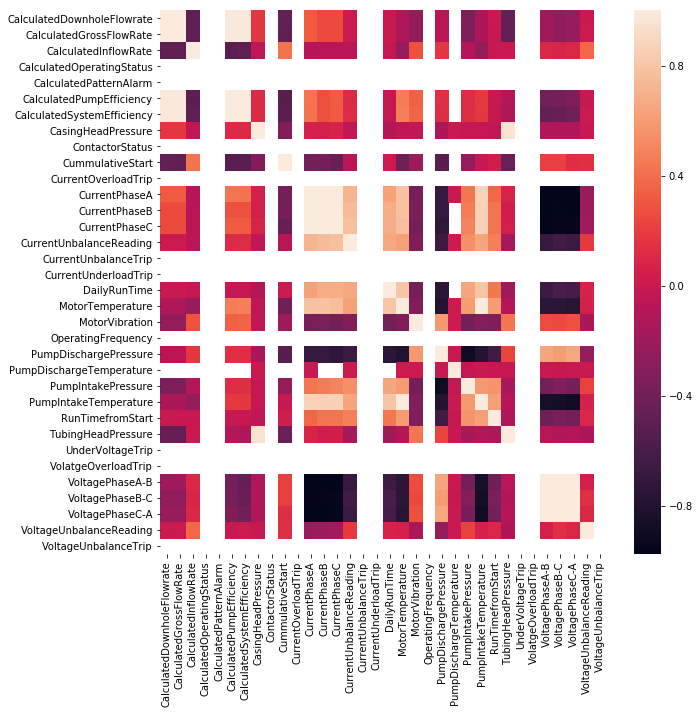

In [57]:
Var_Corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False)

In [80]:
if var_name in data_directionary.keys():
    master_df = data_directionary[var_name]
else:
    df = pd.DataFrame(columns=['corpid','udc','Value','Timestamp'])
    data_directionary[var_name] = df
    master_df = df

In [17]:
count = 0

for subdir, dirs, files in os.walk(data_path):
    for dirname in dirs:
        count += 1
        well_dir = data_path + dirname + '/'
        print(count, well_dir)
        
        output_path_dir =  output_path + dirname + '/'
        directory = os.path.dirname(output_path_dir)

        try:
            os.stat(directory)
        except:
            os.mkdir(directory) 
        
        for subdir, dirs, files in os.walk(well_dir):
            for moni_file in files:
                #do some stuff
                var_name = moni_file.split('_')[1].split('.')[0]
                #print(well_dir)
                #print(moni_file)
                print(var_name)
                
                data_df = pd.read_csv(well_dir + moni_file)
                data_df['Datetime'] = data_df['Timestamp'].apply(lambda x: parser.parse(x)) 
                data_df.drop(['Tag','Timestamp'], axis=1, inplace=True) 
                
                #filename = output_path_dir + var_name + '.pickle'
               # with open(filename, 'wb') as handle:
                    #pickle.dump(data_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
                #del data_df


In [ ]:
data_directionary = OrderedDict()
count = 0
for subdir, dirs, files in os.walk(data_path):
    for dirname in dirs:
        count += 1
        well_dir = data_path + dirname + '/'
        print(count, well_dir)
        for subdir, dirs, files in os.walk(well_dir):
            for moni_file in files:
                #do some stuff
                var_name = moni_file.split('_')[1].split('.')[0]
                #print(well_dir)
                #print(moni_file)
                #print(var_name)
                
                if var_name in data_directionary.keys():
                    master_df = data_directionary[var_name]
                else:
                    #df = pd.DataFrame(columns=['corpid','udc','Tag','Value','Timestamp'])
                    master_df = pd.DataFrame(columns=['corpid','udc','Value','Timestamp'])
                    data_directionary[var_name] = master_df
                data_df = pd.read_csv(well_dir + moni_file);
                data_df.drop('Tag', axis=1, inplace=True) 
                master_df = master_df.append(data_df, ignore_index=True)
                del data_df
                #master_df = pd.concat([master_df, data_df])
                data_directionary[var_name] = master_df

In [140]:
output_path = '/home/'

In [141]:
for key, value in data_directionary.items():
    print(key)
    filename = output_path + key + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(value, handle, protocol=pickle.HIGHEST_PROTOCOL)

VBCSCALED
DWNHOLIA
TORQLBFT
RPMPUMP
TEMPCSU
CSUPRESS
ICMOTOR
IUNBAL
VIBX
STATUS
FREQOUT
VOLT
IBMOTOR
DWNHOLIB
AMPS
VCASCALED
VABSCALED
VIBY
RPMMOTOR
TMOTOR
IAMOTOR
VUNBAL
DWNHOLIC
